In [ ]:
# the most coarse grained model
# state transition/Marcov model (maybe)
#

In [9]:
import pickle
import gzip
import matplotlib.pyplot as plt
import random
import warnings
import datafunctions
import definitions_2018 as bd
import displayfunctions as bp

datafunctions.init(bd) 
bp.init(bd)

warnings.filterwarnings("ignore")

d:\desk\github_related\honey-bee-behavior\foraging_model\definitions_2018.py:20: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  cohort_birthdates = np.array([pd.Timestamp(np.array(cohort_data['DOB'][cohort_data['cohort']==c])[0],freq='D') for c in cohort_colornames])


In [7]:
comb_contents_dir="../../comb-contents-images/"
daynum=0
comb1 = pickle.load(gzip.open(comb_contents_dir+'comb_00'+'.pklz','rb'))
comb2 = pickle.load(gzip.open(comb_contents_dir+'comb_03'+'.pklz','rb'))

Colors denote the different comb areas
Green – empty comb
Blue – brood
Dark blue – capped brood (we can/should probably just group all brood into one group)
Yellow – honey
Orange – pollen
Grey – peripheral galleries
Brown – wooden frames
Pink circles – dances observed during tracing (the general area is the dancefloor)


In [16]:
comb1.getsubstrate(0,100,100)

[6.0]

In [3]:
import pandas as pd
import numpy as np

In [15]:
df1min_dir="../df_day1min_alldays/"
daynum=49
df=pd.read_hdf(('{}df_day1min_{:0>2}.hdf'.format(df1min_dir,daynum)))

In [29]:
bees_trajectory_dir = "../../beetrajectories_days_000_to_049/"
daynum=49
dfday = pd.read_hdf('{}beetrajectories_{:0>3}.hdf'.format(bees_trajectory_dir,daynum))

numtimedivs = len(df['timedivision'].unique()) # minutes in a day
day_uids, day_ages, all_inhive, bee_obs, bee_exitdist = datafunctions.get_inout_estimates(df,numtimedivs=numtimedivs)
#all_inhive is a 2d np array. The ith row and jth column is the state of the bee with uid day_uids[i] at time j.
#1 indicates inhive and 0 the opposite

In [73]:
df.columns

Index(['Age', 'Num. observations', 'Honey', 'Brood care', 'Pollen',
       'Dance floor', 'Other', 'Frame 0', 'Frame 1', 'Frame 2', 'Frame 3',
       'Frame 4', 'Frame 5', 'Median speed', 'Speed IQR',
       'Speed 90th quantile', 'Dispersion (avg)', 'Exit distance (median)',
       'Fraction squares visited', 'Day number', 'Festoon', 'Empty comb',
       'blank1', 'blank2', 'Bee unique ID', 'Cohort ID', 'Num. outside trips',
       'Num. dance floor visits', 'Dispersion-minute avg.',
       'Frame 0 - Num. crossings', 'Frame 1 - Num. crossings',
       'Frame 2 - Num. crossings', 'Frame 3 - Num. crossings',
       'Frame 4 - Num. crossings', 'Frame 5 - Num. crossings', 'timedivision'],
      dtype='object')

In [45]:

non_nan_observations = df[df['Num. observations'].notna()]

# 打印结果
print(non_nan_observations)

          Age  Num. observations     Honey  Brood care  Pollen  Dance floor  \
89       23.0              179.0  1.000000    0.000000     0.0          0.0   
96       23.0              143.0  0.000000    0.003330     0.0          0.0   
111      23.0               56.0  0.238095    0.000000     0.0          0.0   
138      23.0               47.0  1.000000    0.000000     0.0          0.0   
183      23.0               11.0  0.000000    0.000000     0.0          1.0   
...       ...                ...       ...         ...     ...          ...   
1933871   5.0               35.0  1.000000    0.000000     0.0          0.0   
1933875   5.0              177.0  1.000000    0.000000     0.0          0.0   
1933878   5.0              161.0  0.809228    0.000000     0.0          0.0   
1933890   5.0              118.0  0.638418    0.271186     0.0          0.0   
1933910   5.0              175.0  0.000000    0.000000     0.0          0.0   

                Other   Frame 0   Frame 1  Frame 2 

In [50]:
columns_to_sum = ['Honey', 'Brood care', 'Pollen', 'Dance floor', 'Other']
state_distribution_permin = df.groupby('timedivision')[columns_to_sum].sum()
state_distribution_permin.reset_index(inplace=True)

In [60]:
leave_hive_times_list = [np.where(diffs==-1)[0] for diffs in np.diff(all_inhive) ]

[array([1162], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([ 706,  814,  829,  836,  839, 1271, 1279, 1295, 1318], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([133], dtype=int64), array([655, 660, 666, 670], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([988], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([1419], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([ 679, 1149, 1175], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([185], dtype=int64), array([], dtype=int64), array([1242], dtype=int64), arra

In [89]:
honey_sum = np.count_nonzero(all_inhive == 0, axis=0)
# Add a new column 'Honey' to 'state_distribution_permin' with the summed value
state_distribution_permin['Forage'] = honey_sum
columns_to_sum=['Honey', 'Brood care', 'Pollen', 'Dance floor', 'Other','Forage']

In [88]:
state_distribution_permin.head

<bound method NDFrame.head of       timedivision      Honey  Brood care    Pollen  Dance floor      Other  \
0              0.0  40.655658   11.541036  1.585427    18.967622  35.250257   
1              1.0  36.689524   12.232549  1.767084    12.079345  39.231498   
2              2.0  34.792867   12.499264  1.575285    15.569579  33.563005   
3              3.0  38.304218    7.736148  0.570928    17.714521  35.674184   
4              4.0  39.486709    8.281441  0.322132    16.748375  40.161342   
...            ...        ...         ...       ...          ...        ...   
1435        1435.0  41.292138    7.749749  1.614430    14.926115  31.417568   
1436        1436.0  35.888616    4.472940  0.622888    13.626855  35.388700   
1437        1437.0  42.597002    5.830041  0.450601    10.233419  39.888938   
1438        1438.0  44.761321    8.734787  1.080734     8.706545  41.716613   
1439        1439.0  40.634126   13.172889  1.312185    10.306773  36.574026   

      Forage  
0     

In [46]:
all_inhive.shape

(1343, 1440)

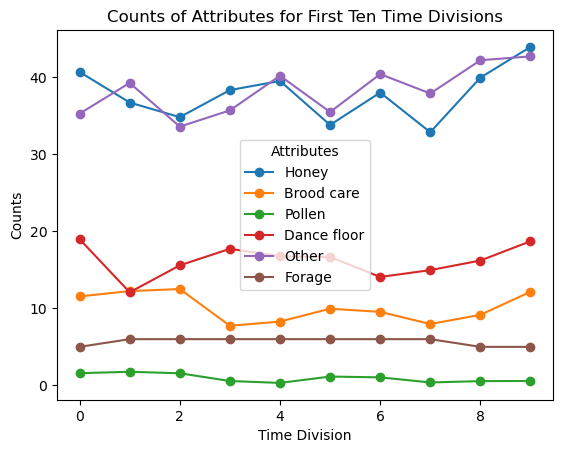

In [91]:
import matplotlib.pyplot as plt

# Subset the grouped data for the first ten 'timedivision' values
subset_grouped = state_distribution_permin.head(10)

# Create a line chart
subset_grouped[columns_to_sum].plot(kind='line', marker='o')
# subset_grouped[['Frame 0', 'Frame 1', 'Frame 2', 'Frame 3', 'Frame 4', 'Frame 5']].plot(kind='line', marker='o')

# Add labels and title
plt.xlabel('Time Division')
plt.ylabel('Counts')
plt.title('Counts of Attributes for First Ten Time Divisions')
plt.legend(title='Attributes')

# Show the plot
plt.show()

In [68]:
subset_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 10 entries, 0.0 to 9.0
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Honey        10 non-null     float64
 1   Brood care   10 non-null     float64
 2   Pollen       10 non-null     float64
 3   Dance floor  10 non-null     float64
 4   Other        10 non-null     float64
dtypes: float64(5)
memory usage: 480.0 bytes


<font size='6'>Train a Linear Regression Model</font>

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [120]:
data=state_distribution_permin
# Feature Engineering: Create lag features
lag_periods = 10  # Choose an appropriate number of lag periods
lag_features = [f'{var}_lag_{i}' for var in columns_to_sum for i in range(1, lag_periods+1)]
for feature in lag_features:
    data[feature] = data[feature.split('_')[0]].shift(int(feature.split('_')[2]))
data=data.iloc[lag_periods:]
# Split data into train and test sets (assuming a time-based split)
train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Define input and output variables
X_train = train_data[columns_to_sum + lag_features].iloc[:-1].values
y_train = train_data['Forage'].diff().iloc[1:].values

X_test = test_data[columns_to_sum + lag_features].iloc[:-1].values
y_test = test_data['Forage'].diff().iloc[1:].values

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on test data
y_pred = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.2183336063700003


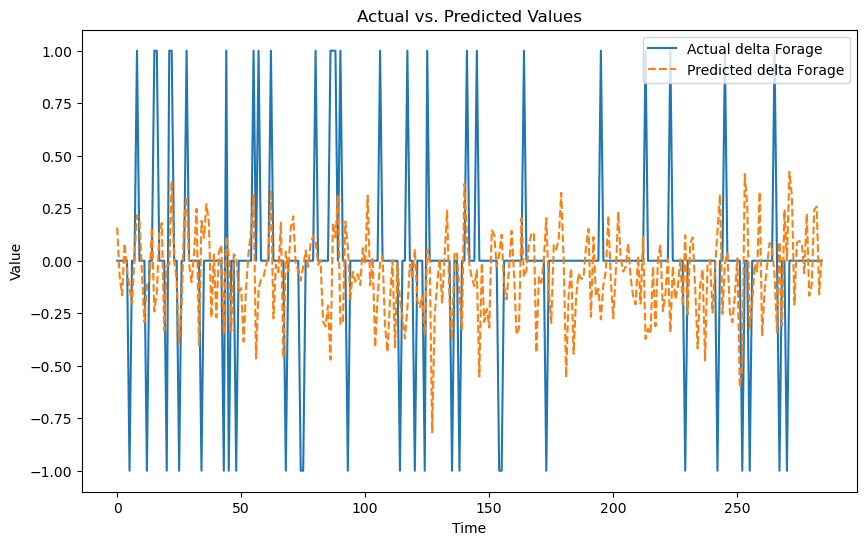

In [123]:
import matplotlib.pyplot as plt

# ... (previous code remains unchanged)

# Make predictions on test data
y_pred = model.predict(X_test)

# Create a line chart plot to compare predicted and actual values
plt.figure(figsize=(10, 6))

for i, column in enumerate(["Forage"]):
    plt.plot(y_test[:], label=f'Actual delta {column}')
    plt.plot(y_pred[:], linestyle='dashed', label=f'Predicted delta {column}')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

In [7]:
obs=[0,1,0,0,0,1,1,1,1,1,0,0,0,0,0]
bins = np.append(np.insert(np.where(np.abs(np.diff(obs).astype(int)))[0]+1,0,0),)
sections = np.array([bins[0:-1],bins[1:]]).T
print(sections)

[[ 0  1]
 [ 1  2]
 [ 2  5]
 [ 5 10]
 [10  5]]


In [53]:
df=pd.read_hdf("../../beetrajectories_days_000_to_049/beetrajectories_049.hdf")
df.head

<bound method NDFrame.head of           daynum  framenum   uid     x     y  camera     theta
0             49      3739  1978  2056  4911       0  2.718270
1             49      3740  1978  2056  4911       0  2.711560
2             49      3741  1978  2056  4911       0  2.635840
3             49      3742  1978  2056  4911       0  2.626750
4             49      3743  1978  1998  4871       0 -1.715170
...          ...       ...   ...   ...   ...     ...       ...
19385602      49    258846  5342  1847  3568       0 -0.214618
19385603      49    258847  5342  1871  3560       0 -0.075922
19385604      49    258848  5342  1888  3560       0  0.050763
19385605      49    258849  5342  1888  3568       0  0.364562
19385606      49    258860  5342  1878  3553       0 -0.492096

[19385607 rows x 7 columns]>

In [62]:
unique_count = df['uid'].unique()
print(unique_count)

[1978 2277 2539 ... 4232 3324 3672]


In [68]:
framenum_ranges = {}

# Iterate through each unique 'uid' value in unique_count
for uid_value in unique_count:
    # Filter the DataFrame based on the current 'uid' value
    filtered_df = df[df['uid'] == uid_value]
    
    # Calculate the minimum and maximum 'framenum' values within the filtered subset
    min_framenum = filtered_df['framenum'].min()
    max_framenum = filtered_df['framenum'].max()
    
    # Store the 'framenum' range in the dictionary
    framenum_ranges[uid_value] = (min_framenum, max_framenum)

# Print the 'framenum' ranges for each 'uid'
for uid_value, framenum_range in framenum_ranges.items():
    print(f"uid {uid_value}: framenum range {framenum_range}")

uid 1978: framenum range (3739, 4941)
uid 2277: framenum range (1797, 222170)
uid 2539: framenum range (2984, 255950)
uid 2630: framenum range (2672, 173584)
uid 2631: framenum range (6014, 248395)
uid 2749: framenum range (1051, 231407)
uid 2781: framenum range (3764, 256376)
uid 2901: framenum range (6337, 259196)
uid 2902: framenum range (2803, 236459)
uid 2945: framenum range (1451, 210596)
uid 3061: framenum range (3597, 255686)
uid 3140: framenum range (10531, 253423)
uid 3154: framenum range (1496, 252724)
uid 3157: framenum range (6882, 205320)
uid 3171: framenum range (1440, 257140)
uid 3186: framenum range (3312, 212282)
uid 3189: framenum range (7177, 259196)
uid 3190: framenum range (2376, 245819)
uid 3194: framenum range (3867, 252659)
uid 3230: framenum range (1061, 175634)
uid 3241: framenum range (5397, 236539)
uid 3255: framenum range (3597, 259199)
uid 3263: framenum range (0, 199573)
uid 3266: framenum range (315, 238241)
uid 3269: framenum range (7374, 234140)
uid 3

In [85]:
filtered_df = df[df['uid'] == 1978]
print(filtered_df.iloc[70:90])
# num_rows = filtered_df.shape[0]
# print(num_rows)

    daynum  framenum   uid     x     y  camera     theta
70      49      3809  1978  1990  4879       0 -1.764870
71      49      3810  1978  1991  4879       0 -1.708790
72      49      3811  1978  1991  4879       0 -1.802350
73      49      3812  1978  1991  4879       0 -1.804090
74      49      3813  1978  1991  4879       0 -1.807370
75      49      3814  1978  2048  4919       0  2.828700
76      49      3815  1978  1991  4879       0 -1.766500
77      49      3816  1978  1991  4879       0 -1.735810
78      49      3817  1978  1991  4879       0 -1.723170
79      49      3823  1978  1991  4879       0 -1.713600
80      49      3834  1978  2056  4728       0  0.992218
81      49      3839  1978  2056  4728       0  0.941120
82      49      3840  1978  2055  4719       0 -2.547180
83      49      3841  1978  2055  4728       0 -0.271713
84      49      3843  1978  2055  4727       0 -2.244820
85      49      3850  1978  2055  4728       0 -0.680178
86      49      4608  1978  199